### Carregamento das Bibliotecas e Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import sys

# Adicionar pasta utils ao path
sys.path.append('./utils')
from generos_onehot import carregar_ou_processar_generos, obter_generos_por_ano, obter_colunas_generos_limpos

# Configurar paths
INPUT_DATA_PATH = './datas/'
OUTPUT_PATH = './outputs/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
# Carregar dados de gêneros processados
df_generos = carregar_ou_processar_generos()
print(f"Colunas de generos criadas: {df_generos.columns.tolist()[3:]}")

Carregando arquivo processado: ./datas/generos_onehot.csv
Dados carregados: (20237, 19)
Nenhum gênero adulto encontrado para remover.
Colunas de generos criadas: ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Comedy', 'Drama', 'Fantasy', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense']


### Preparação dos Dados para Análise Temporal

In [3]:
# Filtrar apenas colunas de year e gêneros para análise temporal
generos_por_ano = obter_generos_por_ano(df_generos)

# Verificar dados
print("\nPrimeira linhas:")
print(generos_por_ano.head(1))

Nenhum gênero adulto encontrado para remover.
Dados agregados por ano: (55, 17)
Anos cobertos: 1970.0 - 2024.0

Primeira linhas:
     year   Action  Adventure  Avant Garde  Award Winning    Comedy     Drama  \
0  1970.0  0.04878   0.146341     0.073171       0.073171  0.341463  0.243902   

    Fantasy  Gourmet  Horror  Mystery  Romance   Sci-Fi  Slice of Life  \
0  0.097561      0.0     0.0      0.0  0.02439  0.02439       0.146341   

     Sports  Supernatural  Suspense  
0  0.341463           0.0       0.0  


In [4]:
# Preparar dados para PCA - usar função utilitária para obter colunas limpas
colunas_generos = obter_colunas_generos_limpos(df_generos)
X = generos_por_ano[colunas_generos].values
anos = generos_por_ano['year'].values

print(f"Matriz de gêneros por ano: {X.shape}")
print(f"Gêneros analisados: {len(colunas_generos)}")
print(f"Anos analisados: {len(anos)}")

Nenhum gênero adulto encontrado para remover.
Matriz de gêneros por ano: (55, 16)
Gêneros analisados: 16
Anos analisados: 55


### Aplicação do PCA

In [5]:
# Padronizar os dados antes do PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reduzir para 2 componentes principais
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensões após PCA: {X_pca.shape}")
print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.3f}")

Dimensões após PCA: (55, 2)
Variância explicada pelo PC1: 0.295
Variância explicada pelo PC2: 0.195
Variância total explicada: 0.490


### Análise dos Componentes Principais

Cada componente principal é uma combinação linear dos gêneros originais. Os gêneros com maior contribuição (valores absolutos maiores) são os que mais influenciam na direção daquele componente no espaço PCA.

In [6]:
# Examinar quais gêneros mais contribuem para cada componente
componentes_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=colunas_generos
)

print("Gêneros que mais contribuem para o Primeiro Componente Principal:")
pc1_contrib = componentes_df['PC1'].abs().sort_values(ascending=False)
print(pc1_contrib.head(5))

print("\nGêneros que mais contribuem para o Segundo Componente Principal:")
pc2_contrib = componentes_df['PC2'].abs().sort_values(ascending=False)
print(pc2_contrib.head(5))

Gêneros que mais contribuem para o Primeiro Componente Principal:
Suspense        0.379017
Supernatural    0.334499
Fantasy         0.309629
Adventure       0.298618
Gourmet         0.291318
Name: PC1, dtype: float64

Gêneros que mais contribuem para o Segundo Componente Principal:
Action           0.417399
Sci-Fi           0.409601
Slice of Life    0.359525
Adventure        0.355128
Drama            0.274054
Name: PC2, dtype: float64


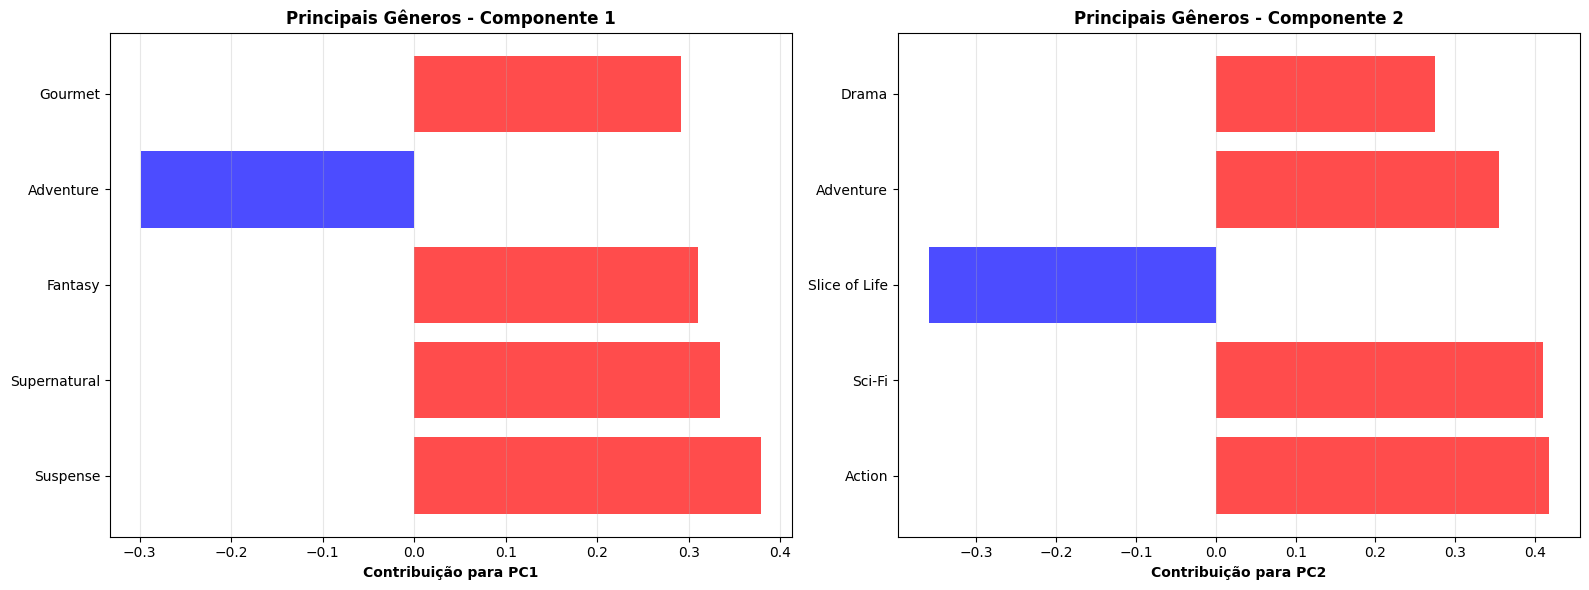

In [7]:
# Visualizar contribuições dos gêneros para os componentes principais
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PC1
top_pc1 = componentes_df['PC1'].abs().sort_values(ascending=False).head(5)
colors_pc1 = ['red' if x > 0 else 'blue' for x in componentes_df.loc[top_pc1.index, 'PC1']]
ax1.barh(range(len(top_pc1)), componentes_df.loc[top_pc1.index, 'PC1'], color=colors_pc1, alpha=0.7)
ax1.set_yticks(range(len(top_pc1)))
ax1.set_yticklabels(top_pc1.index, fontsize=10)
ax1.set_xlabel('Contribuição para PC1', fontweight='bold')
ax1.set_title('Principais Gêneros - Componente 1', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# PC2
top_pc2 = componentes_df['PC2'].abs().sort_values(ascending=False).head(5)
colors_pc2 = ['red' if x > 0 else 'blue' for x in componentes_df.loc[top_pc2.index, 'PC2']]
ax2.barh(range(len(top_pc2)), componentes_df.loc[top_pc2.index, 'PC2'], color=colors_pc2, alpha=0.7)
ax2.set_yticks(range(len(top_pc2)))
ax2.set_yticklabels(top_pc2.index, fontsize=10)
ax2.set_xlabel('Contribuição para PC2', fontweight='bold')
ax2.set_title('Principais Gêneros - Componente 2', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'nb1_pca_componentes_generos.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

**Baseado nos valores das principais componentes:** os anos mais a esquerda do gráfico simbolizam uma preferencia pelo genero Adventure e menores tendencias dos gêneros Gourmet, Fantasy, Supernatural e Suspense, enquanto anos mais a direita mostram o extremo oposto a isso.
O mesmo se aplica a anos mais a abaixo no gráfico, represemtando uma menor presença dos gêneros Drama, Adventure, Sci-Fi e Action e maior presença do genero Slice of Life.

### Visualização: Scatter Plot 2D dos Anos

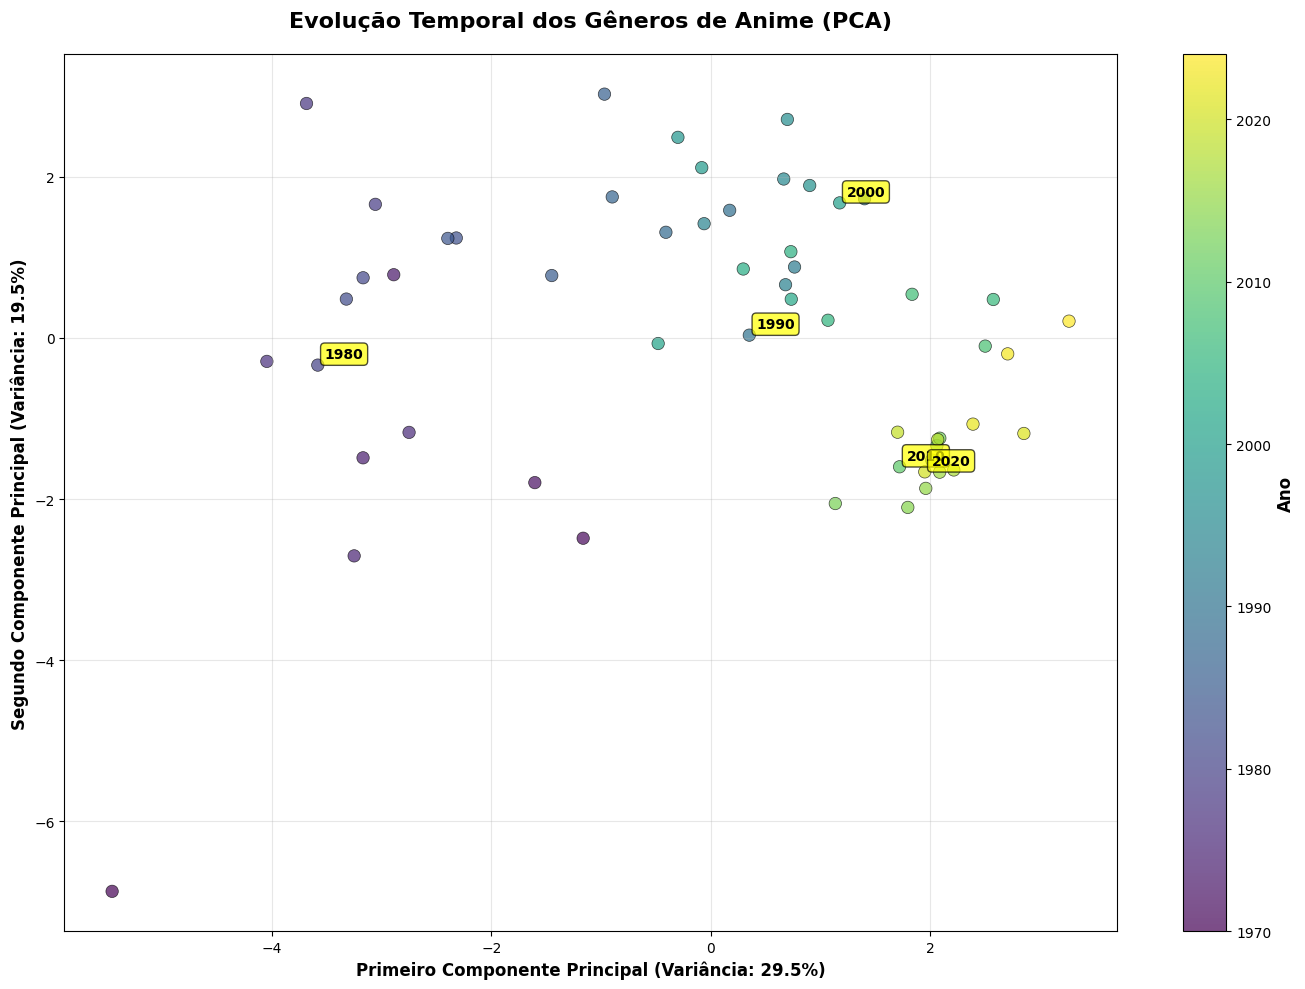

In [8]:
plt.figure(figsize=(14, 10))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                    c=anos, 
                    cmap='viridis', 
                    s=80, 
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Ano', fontsize=12, fontweight='bold')

# Adicionar rótulos para alguns anos importantes
anos_importantes = [1980, 1990, 2000, 2010, 2020]
for i, ano in enumerate(anos):
    if int(ano) in anos_importantes:
        plt.annotate(f'{int(ano)}', 
                    (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=10, 
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Configurar gráfico
plt.xlabel(f'Primeiro Componente Principal (Variância: {pca.explained_variance_ratio_[0]:.1%})', 
            fontsize=12, fontweight='bold')
plt.ylabel(f'Segundo Componente Principal (Variância: {pca.explained_variance_ratio_[1]:.1%})', 
            fontsize=12, fontweight='bold')
plt.title('Evolução Temporal dos Gêneros de Anime (PCA)', 
            fontsize=16, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_PATH, 'nb1_pca_temporal_generos.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

A forma com a qual os anos estão espalhados, demonstra que no passar dos anos os genereros dominantes mudaram, porém de forma gradual. Além disso, aparenta-se ter ocorrido uma tendencia de que mais animes de certos generos tenham sido lançados entre as decadas de 2010 e 2020, devido a aproximação entre os pontos desses anos em uma certa região do gráfico.

### Análise por Décadas

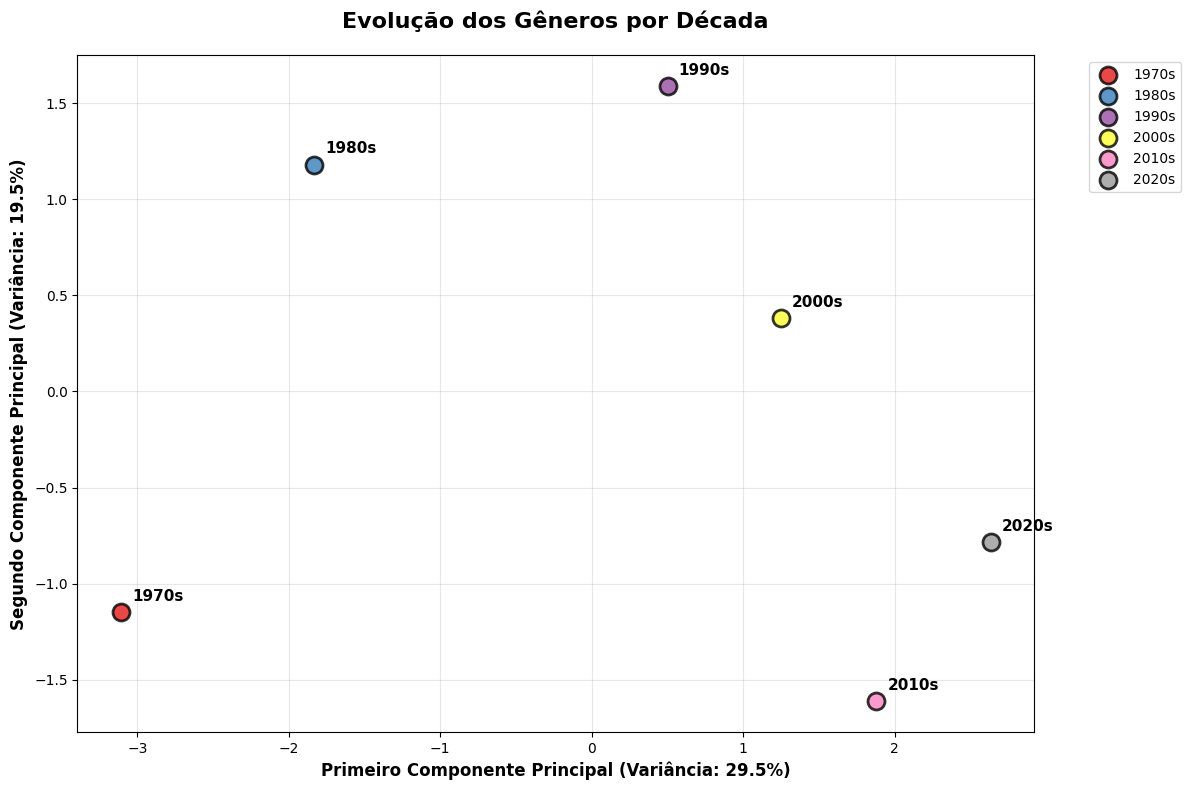

In [9]:
# Media das decadas
generos_por_ano['decada'] = (generos_por_ano['year'] // 10) * 10
generos_por_decada = generos_por_ano.groupby('decada')[colunas_generos].mean().reset_index()

# Aplica o mesmo PCA nas décadas
X_decada = generos_por_decada[colunas_generos].values
X_decada_scaled = scaler.transform(X_decada) 
X_decada_pca = pca.transform(X_decada_scaled)

# Plotar por décadas
plt.figure(figsize=(12, 8))

decadas = generos_por_decada['decada'].values
colors_decada = plt.cm.Set1(np.linspace(0, 1, len(decadas)))

for i, decada in enumerate(decadas):
    plt.scatter(X_decada_pca[i, 0], X_decada_pca[i, 1], 
                c=[colors_decada[i]], 
                s=150, 
                label=f'{int(decada)}s',
                alpha=0.8,
                edgecolors='black',
                linewidth=2)
    
    # Adicionar rótulo da década
    plt.annotate(f'{int(decada)}s', 
                (X_decada_pca[i, 0], X_decada_pca[i, 1]),
                xytext=(8, 8), 
                textcoords='offset points',
                fontsize=11, 
                fontweight='bold')

plt.xlabel(f'Primeiro Componente Principal (Variância: {pca.explained_variance_ratio_[0]:.1%})', 
            fontsize=12, fontweight='bold')
plt.ylabel(f'Segundo Componente Principal (Variância: {pca.explained_variance_ratio_[1]:.1%})', 
            fontsize=12, fontweight='bold')
plt.title('Evolução dos Gêneros por Década', 
            fontsize=16, fontweight='bold', pad=20)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_PATH, 'nb1_pca_por_decadas.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Explicação dos Resultados

O PCA nos permitiu visualizar a evolução dos gêneros de anime ao longo do tempo em apenas duas dimensões, capturando a maior parte da variação nos dados. Com isso, podemos visualizar que os gêneros populares mudaram significativamente ao longo dos anos. O PCA revela uma clara trajetória temporal, indicando que as preferências do público anime evoluíram, possivelmente refletindo mudanças culturais, tecnológicas e na indústria de anime.

**Principais Descobertas:**

1. **Evolução Temporal Visível**: O gráfico de dispersão mostra claramente como os padrões de gêneros mudaram ao longo das décadas. Os pontos mais escuros (anos mais antigos) tendem a se agrupar em regiões diferentes dos pontos mais claros (anos recentes).

2. **Componentes Principais**: 
   - O **primeiro componente** captura a maior variação e geralmente representa a mudança de gêneros mais tradicionais para gêneros mais modernos.
   - O **segundo componente** pode representar variações sazonais ou mudanças específicas em certas categorias de gêneros.

3. **Tendências por Década**:
   - **Anos 80-90**: Provavelmente dominados por gêneros como Action e Adventure
   - **Anos 2000**: Período de transição com diversificação de gêneros
   - **Anos 2010-2020**: Aumento na popularidade de gêneros como Slice of Life, Comedy e Romance